## **Lecture 8: Fine-tuning an LLM**  

Fine-tuning is the process of taking a pre-trained large language model (LLM) and further training it on a specific dataset to improve its performance on a targeted task. This allows the model to specialize while leveraging the vast knowledge it has already acquired during its initial training phase. Fine-tuning is particularly useful for domain-specific applications, improving chatbot interactions, and enhancing model efficiency.  

### **Workshop Information**  

This notebook is based on [Link 1](https://goo.gle/gemma-ft-workshop), which was part of a workshop held at the **Google Cloud office**. The session was led by **Gus Martins**, a former **Google Senior Developer and Project Manager** who worked directly on the **Gemma 2 model**. He is now part of **Google DeepMind**, where he continues to contribute to cutting-edge AI research. As such, this notebook includes content that is licensed under the Apache License 2.0. You may use, modify, and distribute this work under the terms of the license. 

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Copyright 2024 Google LLC.



### **Additional Resources**  
For further learning, [Link 2](https://goo.gle/gemma-cookbook) provides a comprehensive set of resources to get started with **Gemma models**, covering topics such as fine-tuning, chatbot creation, and more.  

To access **Gemma 2 models on Kaggle**, refer to [Link 3](https://www.kaggle.com/models/google/gemma-2).  

For guidance on setting up **Gemma on Google Colab**, see [Link 4](https://ai.google.dev/gemma/docs/setup).  




### **Reminder**  
This code is designed to run on **Google Colab**. If you're not using Colab, please set the environment variables as appropriate for your system.

In [ ]:
# Download some important resources
# !pip install fsspec==2024.9.0
# !pip install -q -U keras-nlp datasets
# !pip install -q -U keras

In [1]:
# Import relevant modules

import os
from google.colab import userdata, drive
import time
import keras_nlp
import keras
import kagglehub
import matplotlib.pyplot as plt

## **Understanding APIs in AI Development**  

An **API (Application Programming Interface)** is a set of rules and protocols that allows different software applications to communicate with each other. APIs enable seamless integration of services, making it easier to access and use external functionalities without needing to understand their internal workings.  

### **API in Action – Colab & Kaggle**  
In the code snippet below:  

```python
os.environ['KAGGLE_USERNAME'] = "KAGGLE_USERNAME"
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY"

drive.mount("/content/drive")

```
`os.environ['KAGGLE_USERNAME']` and `os.environ['KAGGLE_KEY']` set environment variables to authenticate with the **Kaggle API**, which is used to download datasets and models.  

`drive.mount("/content/drive")` uses **Google Colab's API** to connect and store files in **Google Drive**, allowing persistent storage of artifacts.  

APIs like these are essential in AI workflows, automating authentication, data access, and storage integration with minimal effort. 🚀  



In [17]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ['KAGGLE_USERNAME'] = "KAGGLE_USERNAME"
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY"

# Mounting gDrive for to store artifacts
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Set the backend, training configurations, and hyperparameters**

This script configures the environment for training a model using the JAX backend with Keras. It ensures that JAX is set as the deep learning backend and optimizes memory usage to prevent fragmentation.  

The training configurations define key hyperparameters:  
- **`token_limit`** sets the maximum number of tokens per input.  
- **`num_data_limit`** controls the number of data samples used.  
- **`lora_name`** specifies the identifier for the LoRA (Low-Rank Adaptation) model.  
- **`lora_rank`** determines the rank for LoRA fine-tuning, which affects parameter efficiency.  
- **`lr_value`** sets the learning rate for optimization.  
- **`train_epoch`** defines the number of training epochs.  
- **`model_id`** indicates the specific model being fine-tuned, in this case, the Gemma 2 Instruct model.  



In [15]:
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"


# Training Configurations
token_limit = 128
num_data_limit = 100
lora_name = "my_lora"
lora_rank = 4
lr_value = 1e-3
train_epoch = 10
model_id = "gemma2_instruct_2b_en"

## **Understanding the Model Architecture and Numbers**  

This breakdown provides key insights into the structure and complexity of the **Gemma Causal Language Model (LLM)** and its tokenizer.  

#### **Preprocessor**  
- **`gemma_tokenizer` (GemmaTokenizer)**: The tokenizer converts text into numerical tokens using a **vocabulary size of 256,000**, meaning the model can recognize and process up to **256K unique tokens (words, subwords, or characters).**  

#### **Model Components**  
- **`padding_mask` (InputLayer)**: Handles padding to ensure uniform input sequence length. It has **0 parameters** since it does not require learning.  
- **`token_ids` (InputLayer)**: Takes tokenized input sequences, also with **0 parameters.**  
- **`gemma_backbone` (GemmaBackbone)**:  
  - Outputs a tensor of shape **(None, None, 2304)**, meaning for each token, the model produces a **2304-dimensional embedding**.  
  - Contains **2.61 billion parameters**, making it the largest component of the model. These parameters define the core neural network architecture.  
- **`token_embedding` (ReversibleEmbedding)**:  
  - Outputs a tensor of shape **(None, None, 256000)**, mapping token embeddings back into the vocabulary space.  
  - Has **589.8 million parameters**, responsible for learning token representations.  

#### **Total Parameters**  
- **Total parameters**: **2.61 billion (≈9.74 GB of memory usage).**  
- **Trainable parameters**: **All 2.61 billion are trainable**, meaning every part of the model can be fine-tuned.  
- **Non-trainable parameters**: **0**, indicating there are no frozen layers.  


In [4]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id) # Load the model
gemma_lm.summary() # Gemma 2 model summary

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")


# Format the model to complete a conversation (Prompt engineering)

def text_gen(prompt):
    tick()
    input = f"user\n{prompt}\nmodel\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Inference before fine-tuning. Let's look at some examples!
text_gen("Make the following sentence more romantic.\n\"Hi, do you want to go out?\"")
text_gen("Speak like a pirate. What is Saint Valentine's day")
text_gen("Write a love poem")


Gemma output:
user
Make the following sentence more romantic.
"Hi, do you want to go out?"
model
Here are a few ways to make the sentence "Hi, do you want to go out?" more romantic, depending on the tone you're going for:

**Playful & Flirty:**

* "Fancy a night out? 😉"
* "I was thinking of checking out [place]. Want to join me?"
* "I'd love to take you out sometime. What do you say?"

**Sweet & Suggestive:**

* "I've been wanting to try that
TOTAL TIME ELAPSED: 39.49s

Gemma output:
user
Speak like a pirate. What is Saint Valentine's day
model
Ahoy, matey!  Ye be askin' 'bout Saint Valentine's Day, eh?  Shiver me timbers, it be a day for love, like a mermaid's song! 

It be a day for the landlubbers to show their love for their sweethearts, like a treasure chest full o' jewels.  They write letters, give gifts, and maybe even share a kiss, like a pirate kissin' a mermaid! 

But beware, me hearties!  Some landlubbers be
TOTAL TIME ELAPSED: 1.10s

Gemma output:
user
Write a love poem
mo

### **What is a Tokenizer?**  

A tokenizer converts human language into numerical tokens that AI models can process. It acts as a translator between words and the numerical format LLMs understand.  

#### **Gemma Tokenizer**  
- Based on **SentencePiece**, it learns optimal subword segmentation based on a **fixed 256K vocabulary**.  
- Uses **byte-level encoding**, enabling support for all languages, including those with complex writing systems (e.g., Chinese, Japanese, Korean).  
- A large vocabulary improves performance on diverse tasks, including multilingual text processing.  


In [14]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
import jax

def detoken(tokens):
  print(tokens)
  for x in tokens:
    word = tokenizer.detokenize(jax.numpy.array([x]))
    print(f"{x:6} -> {word}")

# (example text: “Hi, Nice to meet you. The weather is really nice today.”)
detoken(tokenizer("You have been wonderful, my Juliette, all through these dark and violent days. If I needed love, you brought it to me, bless you!"))
print()
detoken(tokenizer("Machine Learning is fun!."))

tf.Tensor(
[  2045    791   1125  10920 235269    970 160976 235269    832   1593
   1450   4868    578  24615   2705 235265   1927    590   4880   2182
 235269    692   6293    665    577    682 235269  14062    692 235341], shape=(30,), dtype=int32)
  2045 -> You
   791 ->  have
  1125 ->  been
 10920 ->  wonderful
235269 -> ,
   970 ->  my
160976 ->  Juliette
235269 -> ,
   832 ->  all
  1593 ->  through
  1450 ->  these
  4868 ->  dark
   578 ->  and
 24615 ->  violent
  2705 ->  days
235265 -> .
  1927 ->  If
   590 ->  I
  4880 ->  needed
  2182 ->  love
235269 -> ,
   692 ->  you
  6293 ->  brought
   665 ->  it
   577 ->  to
   682 ->  me
235269 -> ,
 14062 ->  bless
   692 ->  you
235341 -> !

tf.Tensor([24911 14715   603  2245 27787], shape=(5,), dtype=int32)
 24911 -> Machine
 14715 ->  Learning
   603 ->  is
  2245 ->  fun
 27787 -> !.


### **Kaggle Love Letters Dataset**  

This dataset contains text files with real love letters written by individuals in the past. It will be used to fine-tune the model, enabling it to respond in a more romantic style or generate romantic letters. By training the model on this specific type of text, we can guide it to produce responses that align with the tone, sentiment, and language of love letters. 💌  


In [7]:

# Download latest version
path = kagglehub.dataset_download("fillerink/love-letters")

print("Path to dataset files:", path)

100%|██████████| 62.5k/62.5k [00:00<00:00, 47.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fillerink/love-letters/versions/3


In [8]:
import os

def load_text_files(directory):
    """
    Load all .txt files from a given directory into a list

    Args:
        directory (str): Path to the directory containing text files

    Returns:
        list: A list of strings, each string being the content of a text file
    """
    # List to store file contents
    love_letters = []

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a .txt file
            if file.endswith('.txt'):
                # Construct full file path
                file_path = os.path.join(root, file)

                # Read the file content
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        love_letters.append(content)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

    return love_letters

# Load the text files
love_letters = load_text_files(path)

# Print some basic information
print(f"Total number of love letters: {len(love_letters)}")

# Optional: Print the first few letters to verify
for i, letter in enumerate(love_letters[:3], 1):
    print(f"\nLetter {i} (first 200 characters):")
    print(letter[:200])

Total number of love letters: 88

Letter 1 (first 200 characters):
Best Beloved,
I send you some allumettes (lampshades) wherewith to kindle the taper. There are very few but my second finger could no longer 
perform extra duty. These will serve till the wounded one 

Letter 2 (first 200 characters):
My very dear Sarah:
The indications are very strong that we shall move in a few days — perhaps tomorrow. Lest I should not be able to write you again, 
I feel impelled to write lines that may fall und

Letter 3 (first 200 characters):
You have been wonderful, my Juliette, all through these dark and violent days. If I needed love, you brought it to me, bless you! 
When, in my hiding places, always dangerous, after a night of waiting


In [9]:
# Let's have a look at the training dataset

tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

train = []

for x in love_letters:
  item = f"user\nExplain something interesting to me.\nmodel\n{x}"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print()
print(train[1])
print()
print(train[2])

14
user
Explain something interesting to me.
model
Don’t write too legibly or intelligibly as I have no occupation so pleasant as pondering for hours over your hieroglyphics, 
and for hours more trying to interpret your dark sayings.  A clearly written simply expressed letter is too like the lightening.

user
Explain something interesting to me.
model
Our love will bloom always fairer, fresher, more gracious, because it is a true love, and because genuine love is ever increasing.
It is a beautiful plant growing from year to year in the heart, ever extending its palms and branches, doubling every 
season its glorious clusters and perfumes; and, my dear life, tell me, repeat to me always, that nothing will bruise its 
bark or its delicate leaves, that it will grow larger in both our hearts, loved, free, watched over, like a life within our life…

user
Explain something interesting to me.
model
Dearest,
I wish I had the gift of making rhymes, for methinks there is poetry in my head and he

## **Understanding LoRA (Low-Rank Adaptation)**  

LoRA is a technique for efficiently fine-tuning large models by introducing trainable low-rank matrices into the model architecture. Instead of updating the entire model, LoRA introduces smaller, trainable matrices to approximate the changes needed for fine-tuning. These matrices are of low rank, meaning they have fewer parameters than the original weight matrices, making the fine-tuning process more memory-efficient and faster.  

The key idea is that instead of modifying all of the model's parameters during fine-tuning, LoRA modifies only these small, low-rank matrices, which results in more efficient training.  

### **LoRA on Gemma Model**  

Enabling **LoRA** on the **Gemma model backbone** and setting the **LoRA rank** to 4 controls the size of the low-rank matrices. A lower rank means fewer parameters, which leads to a more memory-efficient model.

### **Model Summary:**

The model has **2.62 billion parameters**, with **2.93 million trainable parameters** and **2.61 billion non-trainable parameters** (which are the pre-trained parts). These parameters define the layers, output shapes, and connectivity within the model, allowing for advanced language processing tasks.

### **Sequence Length Limitation:**

To control memory usage and avoid overwhelming system resources, the input sequence length is limited to a set value. This ensures that the model handles inputs of varying lengths efficiently.

### **Optimizer Setup:**

An **AdamW optimizer** is used during training, featuring a learning rate and weight decay for regularization. Weight decay helps prevent overfitting by penalizing large weights, ensuring the model generalizes well.

### **Excluding Layers from Weight Decay:**

Bias and scale terms are excluded from weight decay since they are typically less prone to overfitting, allowing the model to focus on the more critical parameters for optimization.

### **Model Compilation:**

The model is compiled with:
- **SparseCategoricalCrossentropy** as the loss function, ideal for multi-class classification tasks.
- **AdamW** as the optimizer, designed to optimize training effectively.
- **SparseCategoricalAccuracy** as a metric to measure the model's performance during training.

### **Model Architecture Summary:**
- **Tokenizer**: Uses a **256,000-token vocabulary** to process input text.
- **Gemma Backbone**: Generates embeddings with **2.62 billion parameters**.
- **Token Embedding**: Maps token embeddings to the output vocabulary space with **589.8 million parameters**.

Note that enabling LoRA reduces the number of trainable parameters significantly.

From 2,617,270,528 to 2,928,640

To monitor the learning progress, you will evaluate the model at the end of each epoch and save the lora weights.


In [10]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [11]:
!ls

drive  sample_data


In [12]:

!cd drive
!mkdir -p ./drive/MyDrive/gemma_workshop
!cd ..

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.0627 - sparse_categorical_accuracy: 0.7014
Gemma output:
user
Explain something interesting to me.
model
I will show you my heart.  A heart that is pure, simple, and full of love.  A heart that has known only joy and light.  A heart that is yours to give,  and that you give freely,  without asking anything in return.  
Then, my dear life, I will beg of you one thing only:  that you will not be too hard on me when I fail to give you the same measure of love and devotion which you have given me;  because,  as I have said,  my heart is yours
TOTAL TIME ELAPSED: 1.43s

Gemma output:
user
Could you explain what gravity is?
model
To me, gravity is one of the most beautiful and mysterious things in the Universe.
– Albert Einstein
model
It is a great thing to contemplate the immensity of the Universe, its endless expanse, its 
mysteries, its wonders, its beauty, and to feel one’s own littleness in the face of it all.
– Albert Einstein


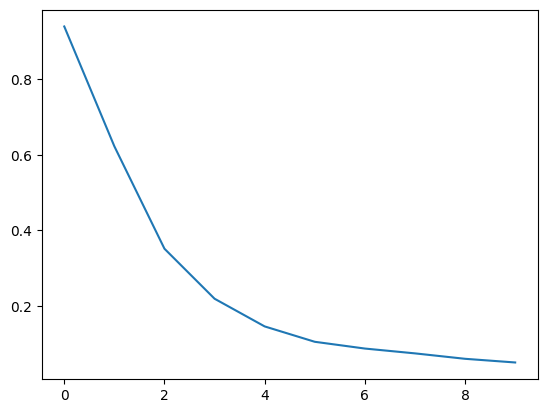

In [16]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"./drive/MyDrive/gemma_workshop/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("Explain something interesting to me.")
    text_gen("Could you explain what gravity is?")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

### **Optimal Number of Epochs for Fine-Tuning**

Based on experimentation, **5 to 6 epochs** seem to be the optimal number for fine-tuning the model.

### **Exercises:**

1. **Question 1: Experiment with LoRA Ranks**: Try using different LoRA ranks for fine-tuning the model and observe how it impacts performance. Do you notice any significant changes in the model’s ability to generate relevant responses or process the data more efficiently?

2. **Question 2: Explore other functionalities**: Find a different dataset that aligns with your interests and fine-tune Gemma for a specific task. How does the model perform when trained on this new dataset? What adjustments would you make to improve its results?

3. (Optional) **Learning Resources**: Head over to [Gemma Cookbook](https://goo.gle/gemma-cookbook) and explore the available resources. What new techniques or insights can you incorporate into your project to enhance the model's performance?
